# direct_pca_clustering

Compressing 3 colour channel galaxy images using principal component analysis. Using the compressed phase space directly in order to cluster the images.

### To do
- Consider weighting features (based on PCA variance importance ranking) for input into the clustering phase space
- Use uncompressed versions of images (i.e. higher resolution than (80, 80) - up to a maximum 424) before passing to PCA

In [22]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans

import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib
import seaborn as sns
import cluster_evaluate

### Loading image data from [`sdss_CNN`](https://github.com/Chris-Duckworth/sdss_CNN) repository 
- Images pre-processed to be (80, 80, 3) in size, and all pixel values (in each colour channel) are normalised to be between 0 and 1.
- No need for sample splitting or 'labels' from CNN directory since we are working with unsupervised learning.
- This normalisation should be fine for input into PCA since all 'dimensions' (i.e. pixel values) span the same range. 
- Flattening information in 3 channel image to 1D array (for each galaxy) for input into the PCA.

In [2]:
data_dir = '../../sdss_CNN/data/cleaned_datasets/'

x = np.load(data_dir + 'x.npy')
features = x.reshape(x.shape[0], -1)

### Principal component analysis
- Implementing PCA with a (semi-arbitrary) 250 output (compressed) features.
- Plotting output features with maximal variance (i.e. best representations of compressed data)

In [18]:
# creating pca object
pca = PCA(n_components=250) 
pca.fit(features)
compressed_features = pca.transform(features)

print('The compressed features explain {:2.2%} of the variance in the image data'.format(np.sum(pca.explained_variance_ratio_)))

The compressed features explain 93.52% of the variance in the image data


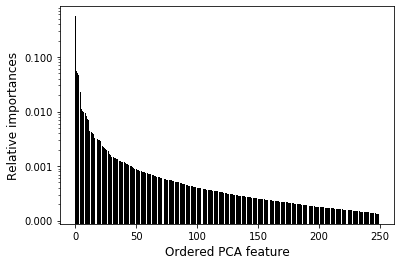

In [19]:
fig = plt.figure()
ax = fig.add_subplot()
ax.bar(x=np.arange(pca.explained_variance_ratio_.shape[0]), height=pca.explained_variance_ratio_, color='k')
ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel('Relative importances', fontsize=12)
ax.set_xlabel('Ordered PCA feature', fontsize=12)
plt.show()

### Reconstructing galaxy images from compressed PCA features

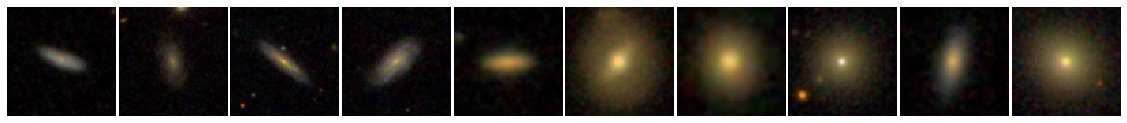

In [20]:
# plotting first 10 galaxy images without PCA dimensionality compression
cluster_evaluate.plot_cluster(x[0:10]) ;

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

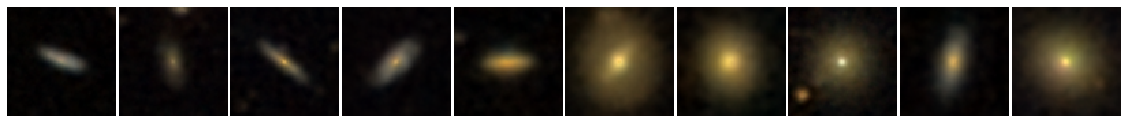

In [21]:
# plotting first 10 galaxy images with PCA dimensionality compression
cluster_evaluate.plot_cluster(pca.inverse_transform(compressed_features).reshape(-1, 80, 80, 3)[0:10] ) ;

### PCA compression appears to throw away minimal information 
- As expected by the 94% variance description of the new _super_-features
- PCA effectively smooths features (could be bad for spirally things!), and, removes noise (i.e. stars) in the frame. 

### K-means clustering 
- To get a baseline for general clustering, lets create 5 clusters of galaxy images and plot examples for each of the clusters

In [33]:
kmeans = KMeans(n_clusters=10, n_jobs=-1)
kmeans.fit(compressed_features)

# extracting cluster labels.
np.unique(kmeans.labels_, return_counts=True)

/opt/miniconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([ 923,  563,  563,  739,  211,   13,  789,  971,  525, 1140]))

Cluster : 0


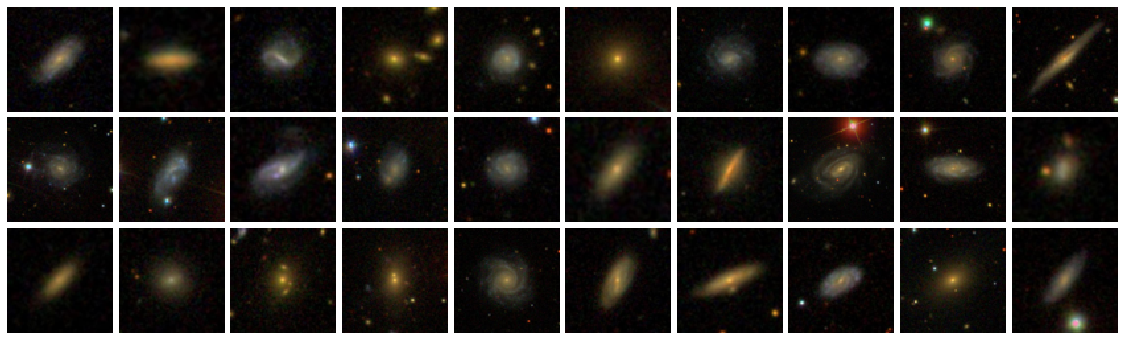

Cluster : 1


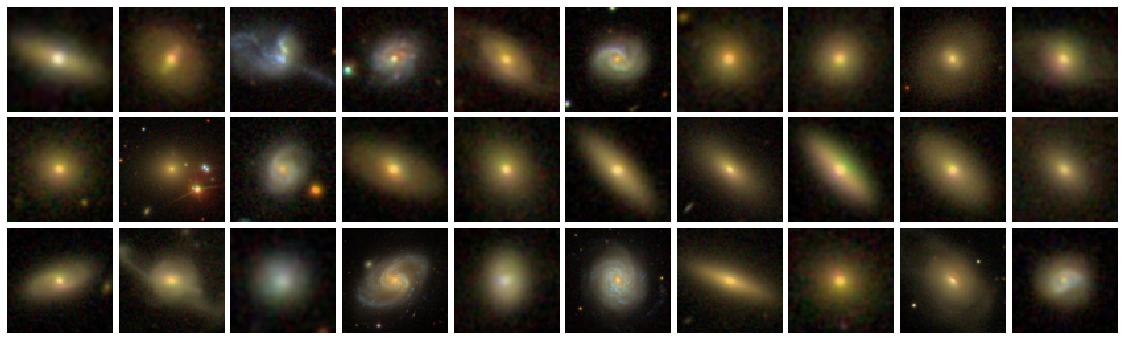

Cluster : 2


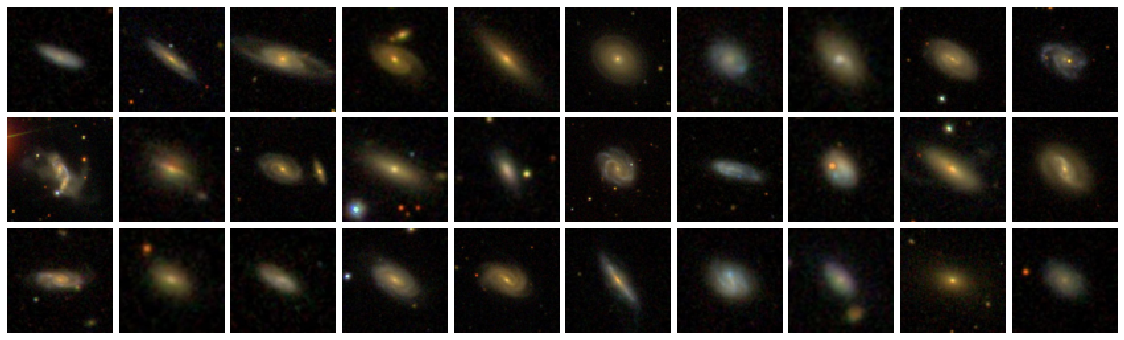

Cluster : 3


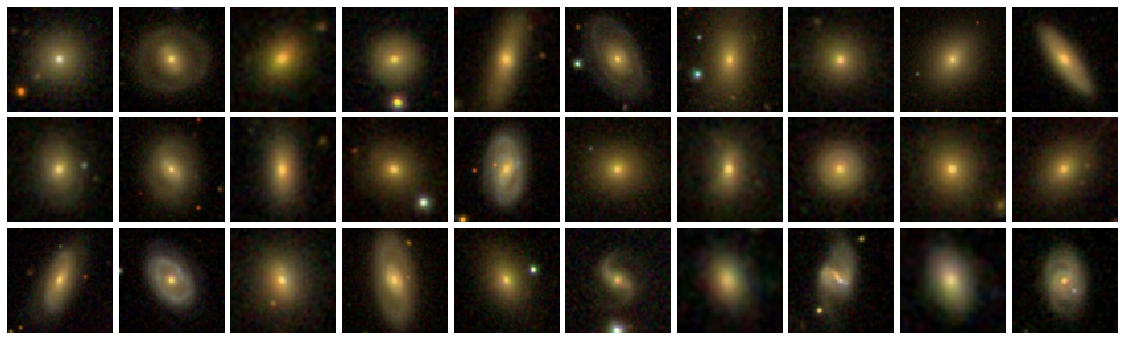

Cluster : 4


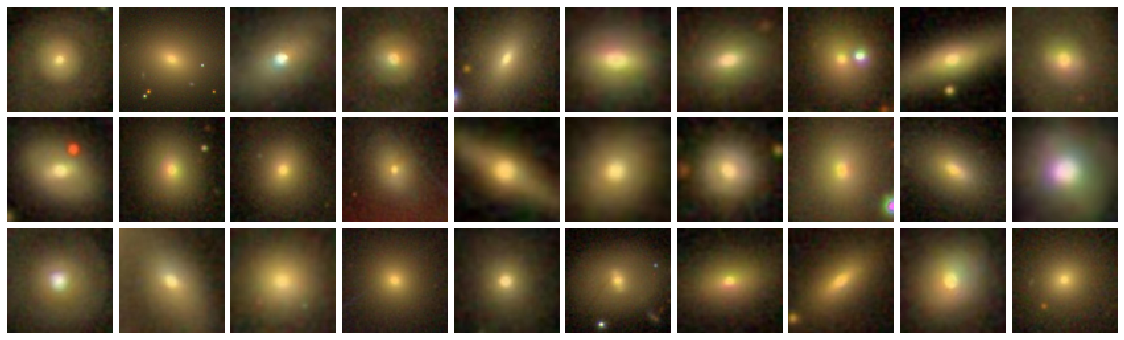

Cluster : 5


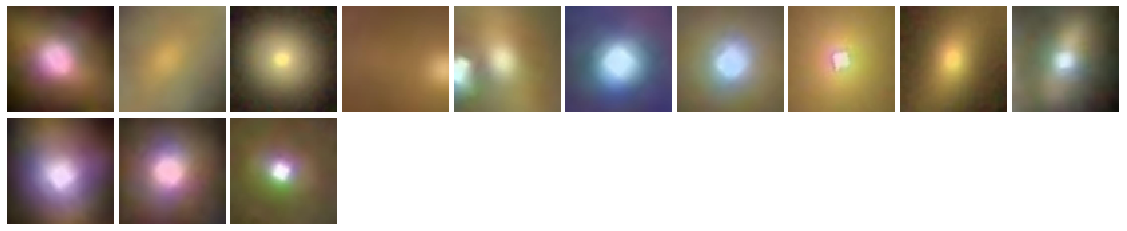

Cluster : 6


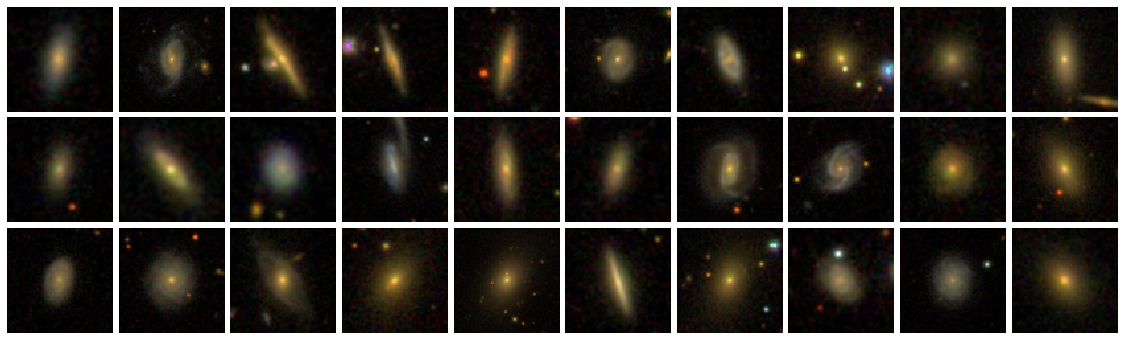

Cluster : 7


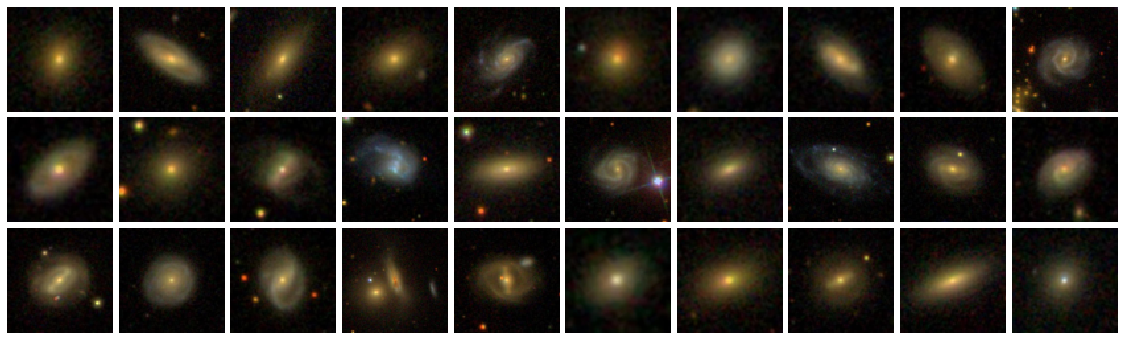

Cluster : 8


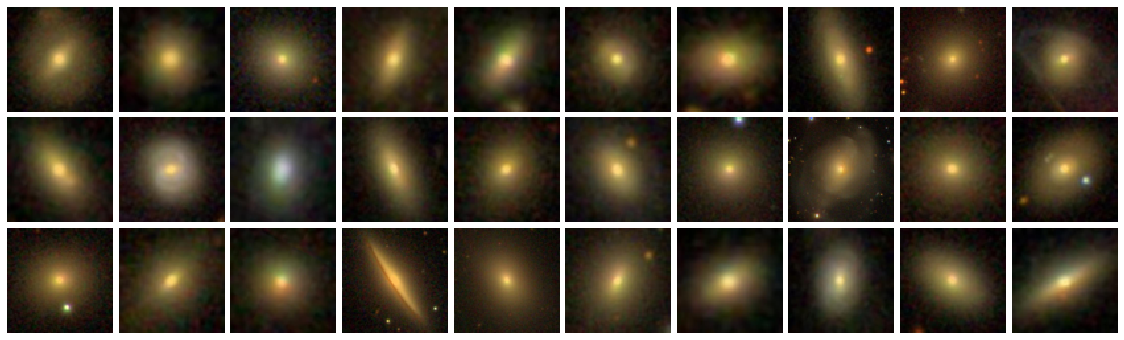

Cluster : 9


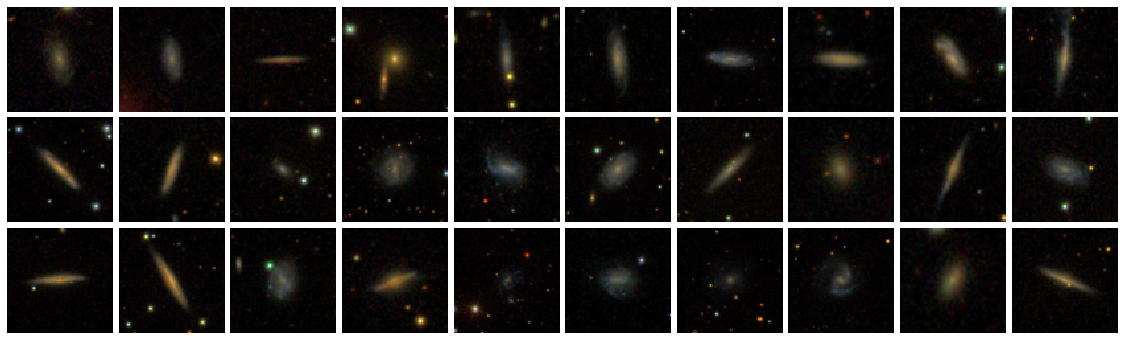

In [35]:
for cluster in np.unique(kmeans.labels_):
    print('Cluster : {}'.format(cluster))
    cluster_evaluate.plot_cluster(x[kmeans.labels_ == cluster][0:30])
    plt.show()

### Summary
- PCA dimensionality reduction appears to do a reasonable job in application for clustering
- Galaxies in clusters appear to well matched in terms of image footprint, inclination and extent. Also appears to do a good job at clustering together images that are just noise.
- Smaller scale structure (such as spiral arms or bars) appear to be missed, and, blu-ish colour tinge doesn't seem to be important for clustering here.